In [3]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, IsolationForest
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

In [4]:
df = pd.read_excel("C:/Users/ADMIN/Documents/COLLEGE/sem6/set/proejc/data/Folds5x2_pp.xlsx")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


<Axes: xlabel='AT', ylabel='Count'>

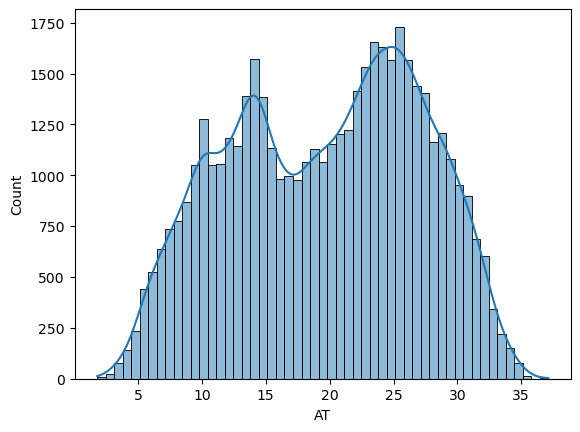

In [6]:
# histograms for each feature
sns.histplot(data = df, x='AT',kde = True)

<Axes: xlabel='V', ylabel='Count'>

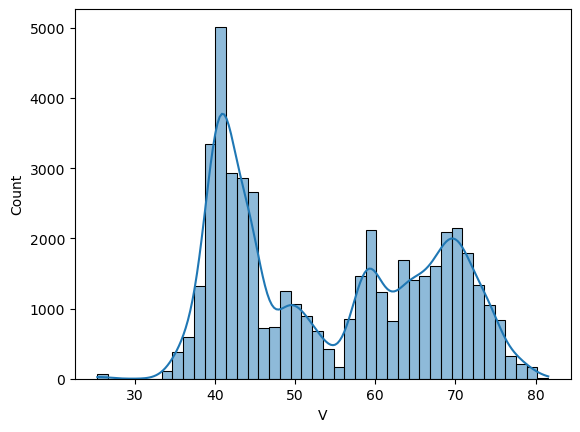

In [8]:
sns.histplot(data = df,x = 'V',kde = True)

<Axes: xlabel='AP', ylabel='Count'>

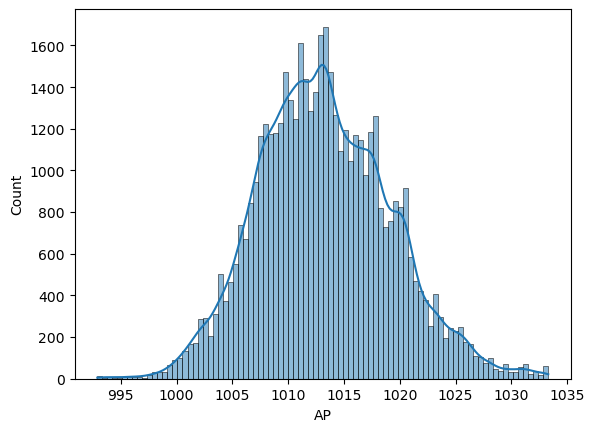

In [9]:
sns.histplot(data = df,x = 'AP',kde = True)

<Axes: xlabel='RH', ylabel='Count'>

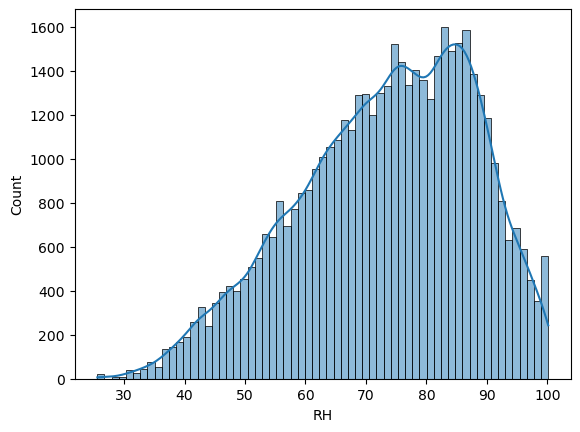

In [10]:
sns.histplot(data = df,x = 'RH',kde = True)

<Axes: xlabel='PE', ylabel='Count'>

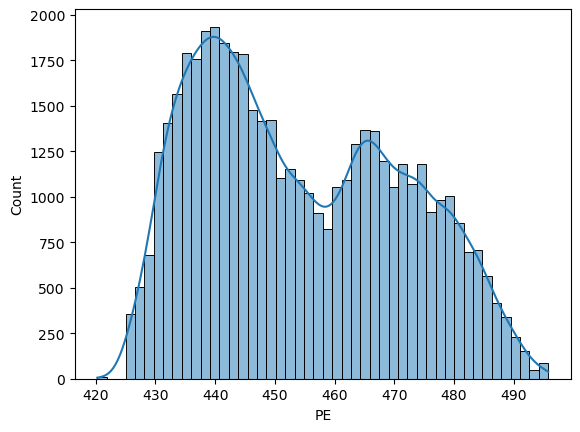

In [11]:
sns.histplot(data = df,x = 'PE',kde = True)

In [12]:
# Basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

                 AT             V            AP            RH            PE
count  47840.000000  47840.000000  47840.000000  47840.000000  47840.000000
mean      19.651231     54.305804   1013.259078     73.308978    454.365009
std        7.452162     12.707362      5.938535     14.599658     17.066281
min        1.810000     25.360000    992.890000     25.560000    420.260000
25%       13.510000     41.740000   1009.100000     63.327500    439.750000
50%       20.345000     52.080000   1012.940000     74.975000    451.550000
75%       25.720000     66.540000   1017.260000     84.830000    468.430000
max       37.110000     81.560000   1033.300000    100.160000    495.760000
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64


In [13]:
X = df[['AT','V','AP','RH']]
y = df['PE']

#train test 60% test/ 40% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# feature normalization

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

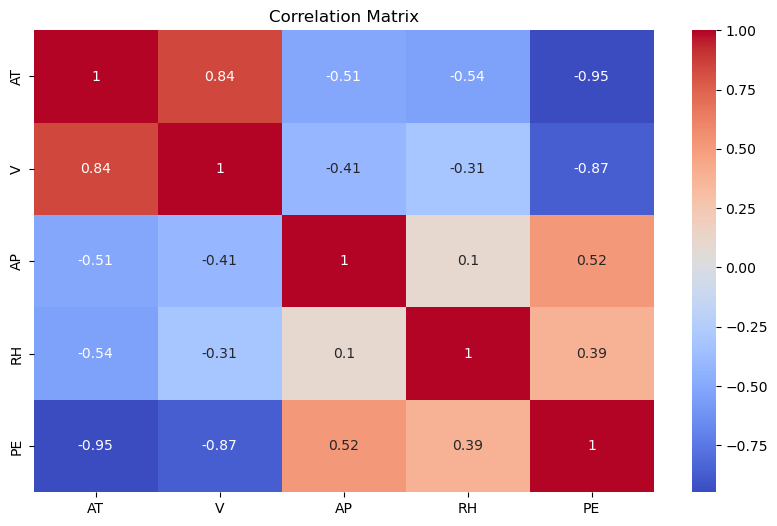

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

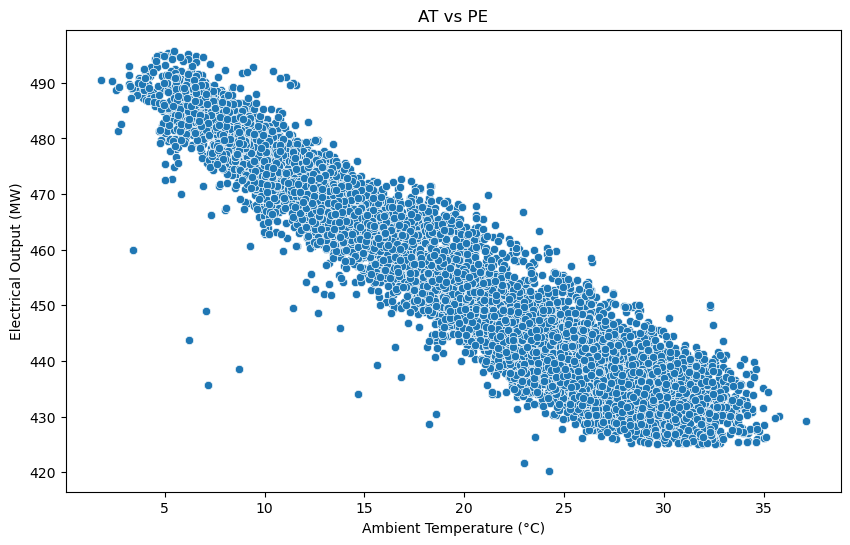

In [16]:
# scatter plots
plt.figure(figsize=(10,6))
sns.scatterplot(x = df['AT'], y = df['PE'])
plt.title("AT vs PE")
plt.xlabel("Ambient Temperature (°C)")
plt.ylabel("Electrical Output (MW)")
plt.show()

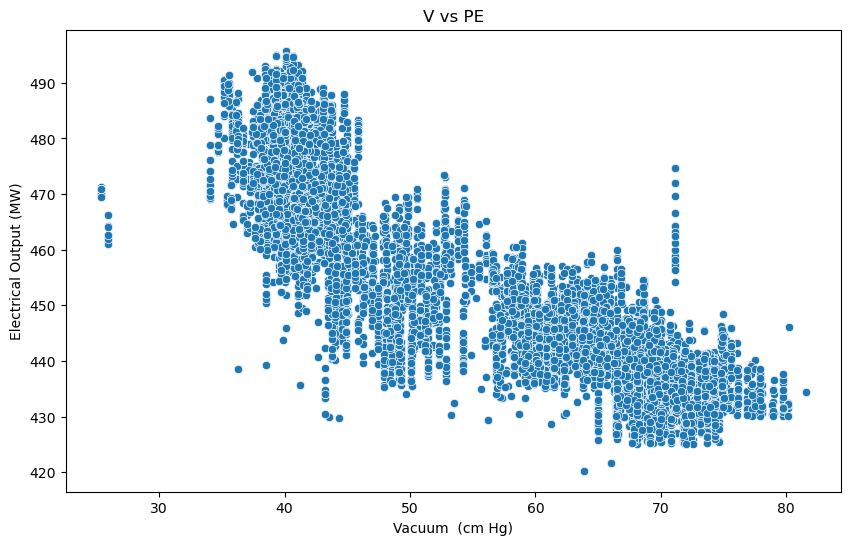

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = df['V'], y = df['PE'])
plt.title("V vs PE")
plt.xlabel("Vacuum  (cm Hg)")
plt.ylabel("Electrical Output (MW)")
plt.show()

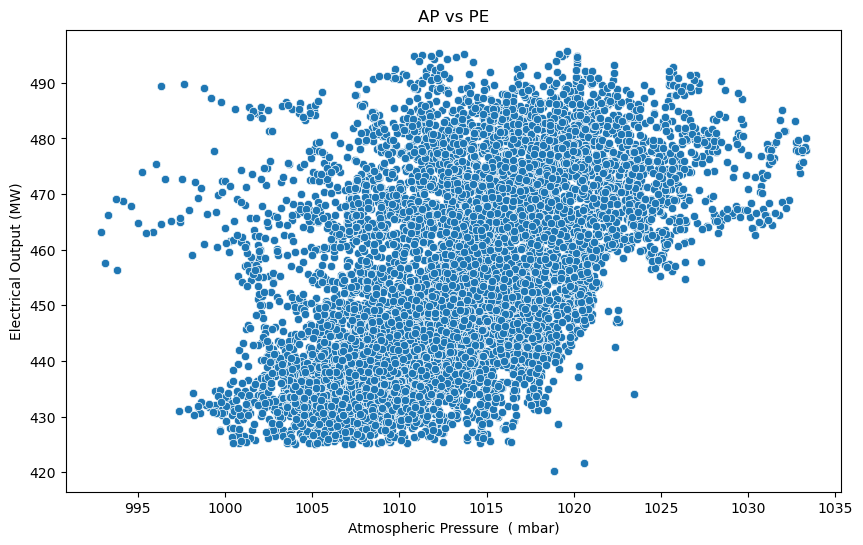

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = df['AP'], y = df['PE'])
plt.title("AP vs PE")
plt.xlabel("Atmospheric Pressure  ( mbar)")
plt.ylabel("Electrical Output (MW)")
plt.show()

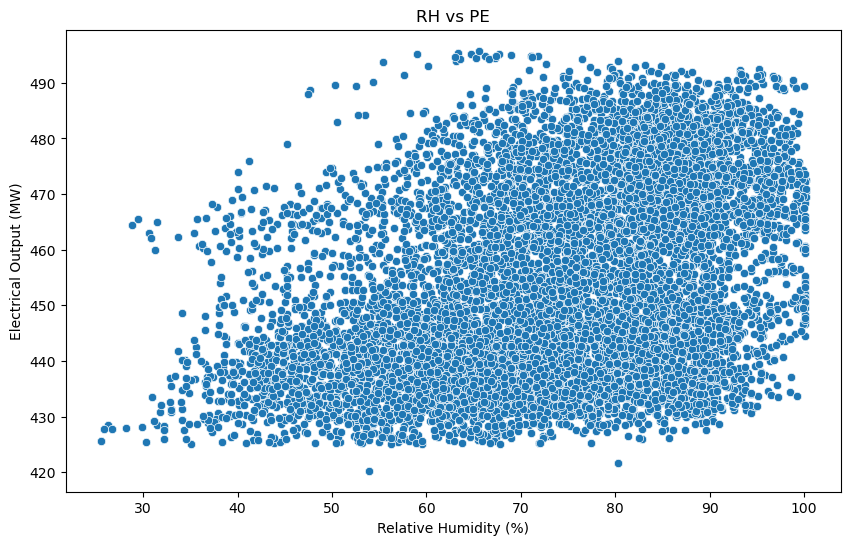

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = df['RH'], y = df['PE'])
plt.title("RH vs PE")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Electrical Output (MW)")
plt.show()

In [22]:
# linear regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression: MAE = {mae_lr:.2f}, RMSE = {rmse_lr:.2f}")

Linear Regression: MAE = 3.62, RMSE = 4.52


In [31]:
# Bagging + REPTree
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=None, min_samples_split=2),
    n_estimators=10,
    random_state=42
)
bagging_model.fit(X_train, y_train)  # No scaling needed for trees
y_pred_bag = bagging_model.predict(X_test)

# Metrics
mae_bag = mean_absolute_error(y_test, y_pred_bag)
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))
print(f"Bagging + REPTree: MAE = {mae_bag:.2f}, RMSE = {rmse_bag:.2f}")

Bagging + REPTree: MAE = 0.39, RMSE = 0.87


In [32]:
# XG BOOST
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost: MAE = {mae_xgb:.2f}, RMSE = {rmse_xgb:.2f}")

XGBoost: MAE = 2.05, RMSE = 2.75


In [25]:
# Calculate residuals
residuals = y_test - y_pred_bag  # Use Bagging model's predictions

# Z-score method
residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)
z_scores = (residuals - residuals_mean) / residuals_std
anomalies_z = np.abs(z_scores) > 3  # Threshold = 3σ

# IQR method
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)
IQR = Q3 - Q1
anomalies_iqr = (residuals < (Q1 - 1.5 * IQR)) | (residuals > (Q3 + 1.5 * IQR))

print(f"Z-score anomalies: {sum(anomalies_z)}")
print(f"IQR anomalies: {sum(anomalies_iqr)}")

Z-score anomalies: 477
IQR anomalies: 5582


In [26]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% anomalies
anomalies_iso = iso_forest.fit_predict(X_test)
anomalies_iso = anomalies_iso == -1  # Convert to boolean

print(f"Isolation Forest anomalies: {sum(anomalies_iso)}")

Isolation Forest anomalies: 192


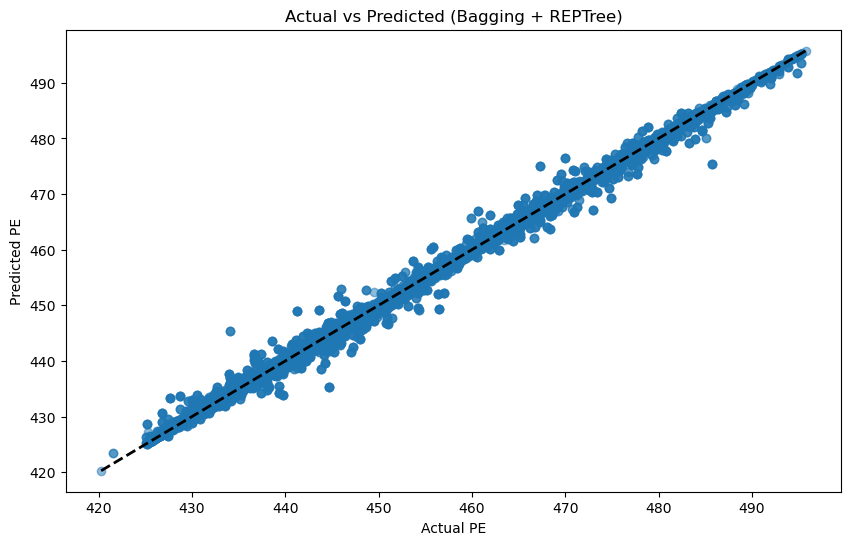

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_bag, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual PE")
plt.ylabel("Predicted PE")
plt.title("Actual vs Predicted (Bagging + REPTree)")
plt.show()

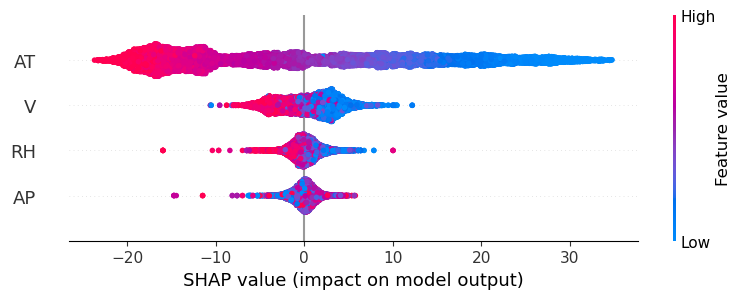

In [29]:
explainer = shap.TreeExplainer(bagging_model.estimators_[0])  # Use first tree
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=['AT', 'V', 'AP', 'RH'])

In [30]:
# Compile results
results = {
    "Model": ["Linear Regression", "Bagging + REPTree", "XGBoost"],
    "MAE": [mae_lr, mae_bag, mae_xgb],
    "RMSE": [rmse_lr, rmse_bag, rmse_xgb]
}
results_df = pd.DataFrame(results)
print(results_df)

# Show anomalies
anomalies_df = X_test.copy()
anomalies_df['PE'] = y_test
anomalies_df['Residual'] = residuals
anomalies_df['Is_Anomaly_Z'] = anomalies_z
anomalies_df['Is_Anomaly_IQR'] = anomalies_iqr
anomalies_df['Is_Anomaly_ISO'] = anomalies_iso

print("Anomalies detected:")
print(anomalies_df[anomalies_df['Is_Anomaly_Z'] | anomalies_df['Is_Anomaly_IQR'] | anomalies_df['Is_Anomaly_ISO']])

               Model       MAE      RMSE
0  Linear Regression  3.622570  4.518926
1  Bagging + REPTree  0.391552  0.873753
2            XGBoost  2.052544  2.747258
Anomalies detected:
          AT      V       AP     RH      PE  Residual  Is_Anomaly_Z  \
22792  13.45  42.44  1012.79  83.12  473.96     1.741         False   
18853  23.09  69.13  1010.93  90.07  436.67    -0.382         False   
45165  26.23  63.56  1013.57  65.81  440.80    -0.594         False   
12618  24.53  74.78  1009.90  78.34  446.30     1.612         False   
10465  25.89  66.49  1013.08  63.16  434.67    -0.502         False   
...      ...    ...      ...    ...     ...       ...           ...   
10884  29.23  68.14  1004.31  81.46  428.87    -0.721         False   
42869  17.66  62.10  1019.49  86.30  452.03    -0.713         False   
35119  26.80  72.58  1009.22  89.03  431.18     0.713         False   
12152  18.68  53.29  1018.16  75.01  459.89     0.398         False   
63     13.76  45.87  1008.89  87.27